We want the following
* images where the stimuli are now pairs of images from the original set
* The option images will always consist of one where the stimuli are the same and one where they are different (according to category)
* The 'test image' will have the same relationship between the categories as one of the option images but never with the same categories
* we want the train dataset to have equal number of match and non-match trials
* we want a count of how often each category is used in the train dataset

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
base_dir = os.path.abspath('../..')
save_dir = os.path.join(base_dir,'results')
data_dir = os.path.join(base_dir,'data')

In [3]:
set_A_ims = np.load(os.path.join(data_dir, 'set_A.npy'))
set_B_ims = np.load(os.path.join(data_dir, 'set_B.npy'))
set_C_ims = np.load(os.path.join(data_dir, 'set_C.npy'))
set_A_labs = np.load(os.path.join(data_dir, 'set_A_labs.npy'))
set_B_labs = np.load(os.path.join(data_dir, 'set_B_labs.npy'))
set_C_labs = np.load(os.path.join(data_dir, 'set_C_labs.npy'))

In [4]:
set_A_matching = []
set_B_matching = []

for i, img_A in enumerate(set_A_ims):
    for j, img_B in enumerate(set_B_ims):
        if np.array_equal(img_A, img_B):
            set_A_matching.append(i)
            set_B_matching.append(j)

matching_indices = (np.array(set_A_matching), np.array(set_B_matching))

In [5]:
def merge_images(images, idx1, idx2):
    """Helper function to merge two images horizontally"""
    img1 = images[idx1]
    img2 = images[idx2]
    return np.hstack((img1, img2))


In [42]:
def create_model_training_dataset(images, labels, n_trials=1000, train_ratio=0.9):
    images = np.array(images) / 255.0  # Normalize to [0,1]
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    
    # Initialize tracking
    category_pairs = []
    trial_difficulties = []
    trials = {
        'test_images': [],
        'option_1_images': [],
        'option_2_images': [],
        'correct_options': [],
        'metadata': []
    }
    
    # Ensure balanced same/different trials
    n_same = n_trials // 2
    n_diff = n_trials - n_same
    
    for is_same in [True, False]:
        n_current = n_same if is_same else n_diff
        
        for _ in range(n_current):
            # Select test categories
            test_cat1 = np.random.choice(unique_labels)
            test_cat2 = test_cat1 if is_same else np.random.choice(unique_labels[unique_labels != test_cat1])
            
            # Select test images
            test_idx1 = np.random.choice(np.where(labels == test_cat1)[0])
            test_idx2 = np.random.choice(np.where(labels == test_cat2)[0])
            test_merged = merge_images(images, test_idx1, test_idx2)
            
            # Create options (randomize order)
            remaining_cats = unique_labels[~np.isin(unique_labels, [test_cat1])]
            
            opt_cats = np.random.choice(remaining_cats, size=3, replace=False)
            
            # Create same-category option
            same_idx1, same_idx2 = np.random.choice(np.where(labels == opt_cats[0])[0], size=2, replace=False)
            same_merged = merge_images(images, same_idx1, same_idx2)
            
            # Create different-category option
            diff_idx1 = np.random.choice(np.where(labels == opt_cats[1])[0])
            diff_idx2 = np.random.choice(np.where(labels == opt_cats[2])[0])
            diff_merged = merge_images(images, diff_idx1, diff_idx2)
            
            # Randomize option order
            if np.random.random() > 0.5:
                option_1, option_2 = same_merged, diff_merged
                correct_option = 0 if is_same else 1
            else:
                option_1, option_2 = diff_merged, same_merged
                correct_option = 1 if is_same else 0
            
            # Store trial data
            trials['test_images'].append(test_merged)
            trials['option_1_images'].append(option_1)
            trials['option_2_images'].append(option_2)
            trials['correct_options'].append(correct_option)
            trials['metadata'].append({
                'test_categories': (test_cat1, test_cat2),
                'is_same': is_same,
                'trial_type': 'same' if is_same else 'different'
            })
    
    # Before converting to numpy arrays, get shuffle indices
    shuffle_idx = np.random.permutation(len(trials['test_images']))
    
    # Apply shuffle to all trial data
    for key in trials.keys():
        trials[key] = [trials[key][i] for i in shuffle_idx]

    # Convert to numpy arrays
    for key in ['test_images', 'option_1_images', 'option_2_images', 'correct_options']:
        trials[key] = np.array(trials[key])
    
    # Split train/test
    n_train = int(n_trials * train_ratio)
    train_data = {k: v[:n_train] for k, v in trials.items()}
    test_data = {k: v[n_train:] for k, v in trials.items()}
    
    return {
        'train': train_data,
        'test': test_data,
        'category_stats': pd.Series([m['test_categories'] for m in trials['metadata']]).value_counts()
    }

In [43]:
all_trials = create_model_training_dataset(set_A_ims, set_A_labs)
training_trials = all_trials['train']

In [44]:
trial_data = []
for i in range(len(b['test_images'])):
    trial_data.append({
        'trial_index': i,
        'test_image': training_trials['test_images'][i],
        'option_1_image': training_trials['option_1_images'][i],
        'option_2_image': training_trials['option_2_images'][i],
        'correct_option': training_trials['correct_options'][i],
        'test_categories': training_trials['metadata'][i]['test_categories'],
        'trial_type': training_trials['metadata'][i]['trial_type']
    })

df = pd.DataFrame(trial_data)

In [45]:
def create_overlapping_dfs(df, size_per_df=300):
    """
    Creates three dataframes with specified overlap constraints
    """
    # Calculate required indices
    all_indices = np.arange(len(df))
    
    # Create df_a
    a_indices = np.random.choice(all_indices, size=size_per_df, replace=False)
    df_a = df.iloc[a_indices].reset_index(drop=True)
    
    # Create df_b with 50% overlap with df_a
    overlap_ab_size = size_per_df // 2
    overlap_ab_indices = np.random.choice(a_indices, size=overlap_ab_size, replace=False)
    remaining_indices = np.setdiff1d(all_indices, a_indices)
    unique_b_indices = np.random.choice(remaining_indices, size=size_per_df-overlap_ab_size, replace=False)
    b_indices = np.concatenate([overlap_ab_indices, unique_b_indices])
    df_b = df.iloc[b_indices].reset_index(drop=True)
    
    # Create df_c with no overlap with df_a and 33.33% overlap with df_b
    overlap_bc_size = size_per_df // 3
    available_from_b = np.setdiff1d(b_indices, a_indices)  # Only use b indices that don't overlap with a
    overlap_bc_indices = np.random.choice(available_from_b, size=overlap_bc_size, replace=False)
    remaining_for_c = np.setdiff1d(all_indices, np.concatenate([a_indices, b_indices]))
    unique_c_indices = np.random.choice(remaining_for_c, size=size_per_df-overlap_bc_size, replace=False)
    c_indices = np.concatenate([overlap_bc_indices, unique_c_indices])
    df_c = df.iloc[c_indices].reset_index(drop=True)
    
    # Verify overlaps
    overlap_stats = {
        'ab_overlap': len(np.intersect1d(a_indices, b_indices)) / size_per_df,
        'ac_overlap': len(np.intersect1d(a_indices, c_indices)) / size_per_df,
        'bc_overlap': len(np.intersect1d(b_indices, c_indices)) / size_per_df
    }
    
    return df_a, df_b, df_c, overlap_stats

In [46]:
df_a, df_b, df_c, overlap_stats = create_overlapping_dfs(df)

In [47]:
df_a.trial_type.value_counts()

trial_type
different    156
same         144
Name: count, dtype: int64

In [48]:
df_b.trial_type.value_counts()

trial_type
different    159
same         141
Name: count, dtype: int64

In [49]:
df_c.trial_type.value_counts()

trial_type
different    151
same         149
Name: count, dtype: int64

In [19]:
def view_trial(dataset, trial_idx=0, split='train'):
    """
    Display a single trial from the dataset with all relevant information
    """
    data = dataset[split]
    
    # Create figure with 3 subplots horizontally
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Trial {trial_idx} ({split} set)', fontsize=14)
    
    # Plot images
    axes[0].imshow(data['test_images'][trial_idx])
    axes[0].set_title('Test Pair')
    axes[0].axis('off')
    
    axes[1].imshow(data['option_1_images'][trial_idx])
    axes[1].set_title('Option 1' + (' ✓' if data['correct_options'][trial_idx] == 0 else ''))
    axes[1].axis('off')
    
    axes[2].imshow(data['option_2_images'][trial_idx])
    axes[2].set_title('Option 2' + (' ✓' if data['correct_options'][trial_idx] == 1 else ''))
    axes[2].axis('off')
    
    # Add metadata as text
    metadata = data['metadata'][trial_idx]
    # plt.figtext(0.02, 0.02, f'Metadata: {metadata}', fontsize=10, wrap=True)
    print(f'Correct Option: {data["correct_options"][trial_idx]}')
    print(f"Metadata: {metadata}")
    
    plt.tight_layout()
    plt.show()
    plt.close()

def view_multiple_trials(dataset, start_idx=0, n_trials=5, split='train'):
    """
    Display multiple trials in sequence
    """
    for idx in range(start_idx, min(start_idx + n_trials, len(dataset[split]['test_images']))):
        print(f"\nViewing trial {idx}")
        view_trial(dataset, idx, split)


Viewing trial 0
Correct Option: 1
Metadata: {'test_categories': (2, 2), 'is_same': True, 'trial_type': 'same'}


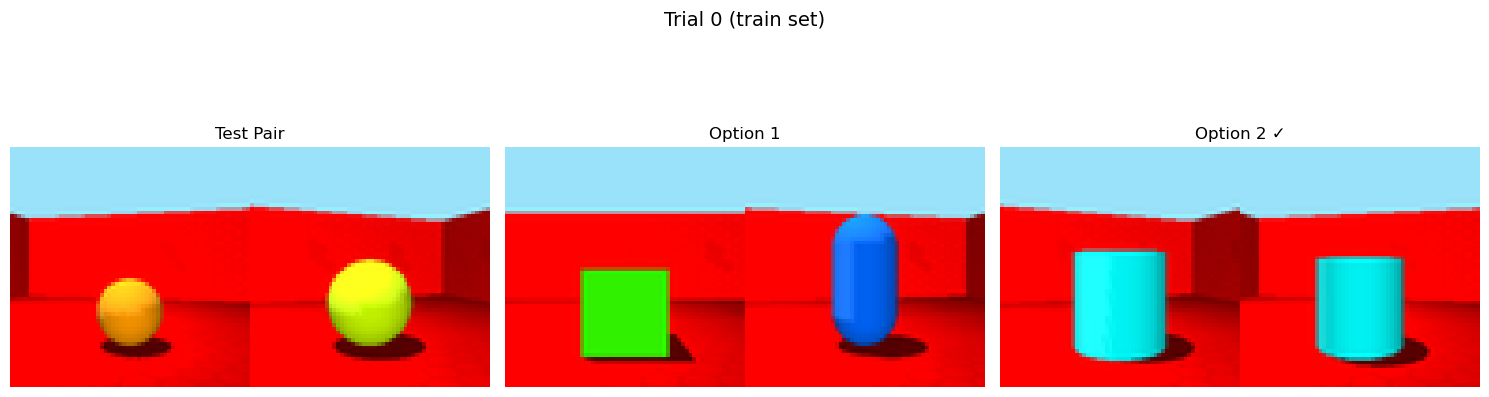


Viewing trial 1
Correct Option: 0
Metadata: {'test_categories': (3, 3), 'is_same': True, 'trial_type': 'same'}


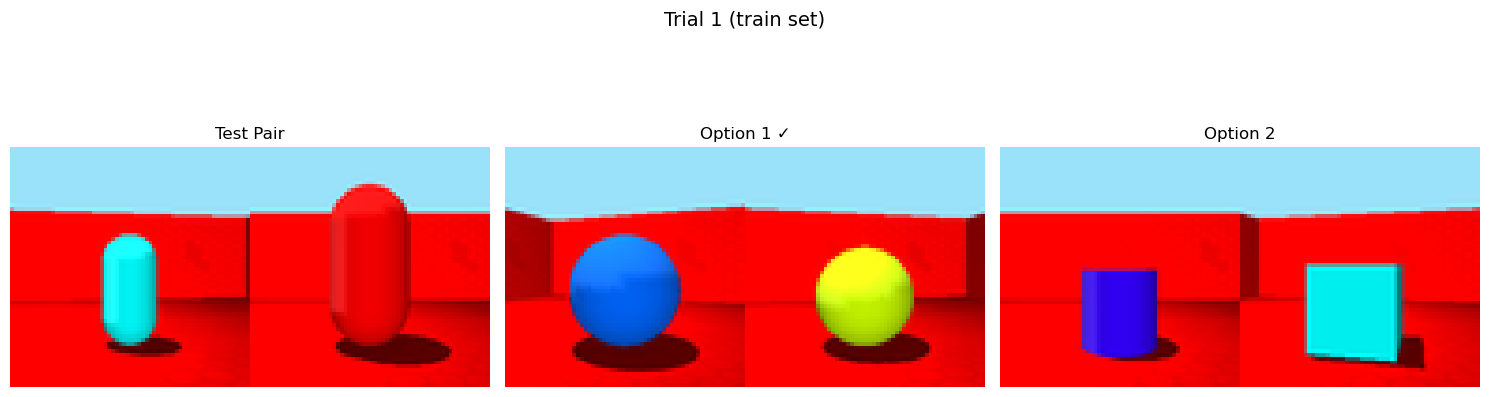


Viewing trial 2
Correct Option: 0
Metadata: {'test_categories': (3, 1), 'is_same': False, 'trial_type': 'different'}


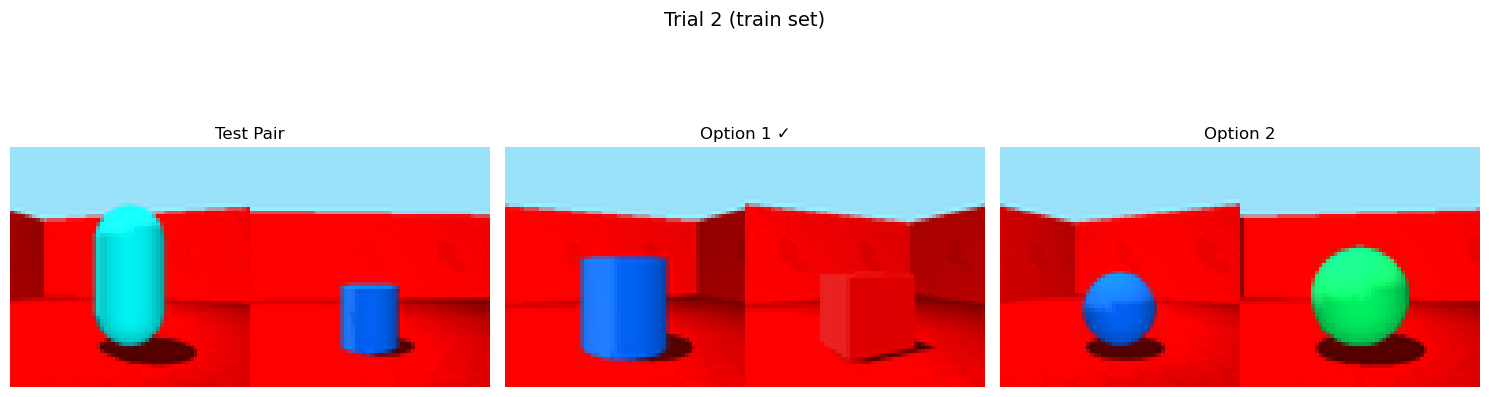


Viewing trial 3
Correct Option: 0
Metadata: {'test_categories': (3, 3), 'is_same': True, 'trial_type': 'same'}


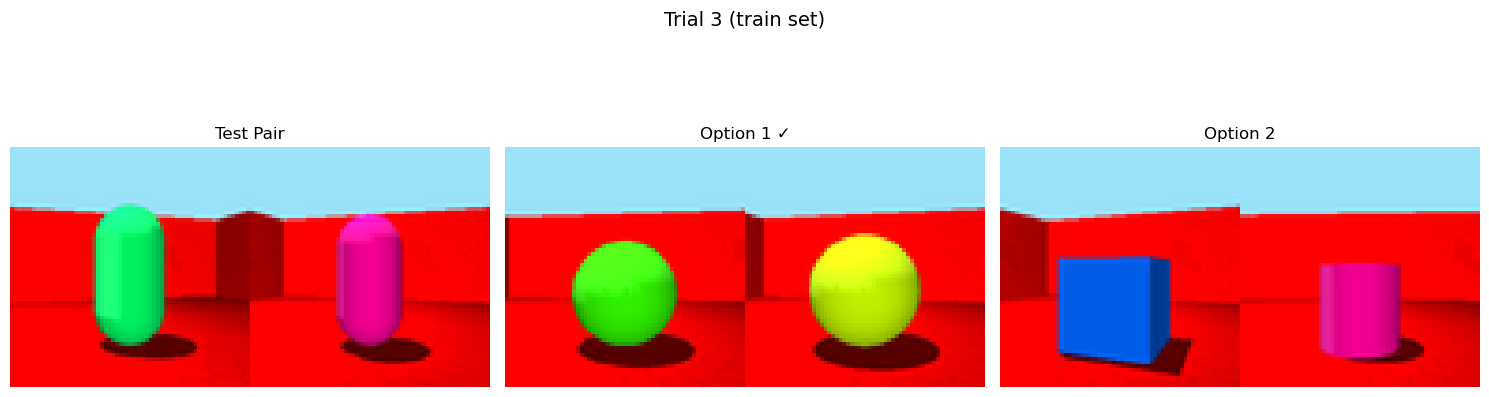


Viewing trial 4
Correct Option: 1
Metadata: {'test_categories': (3, 2), 'is_same': False, 'trial_type': 'different'}


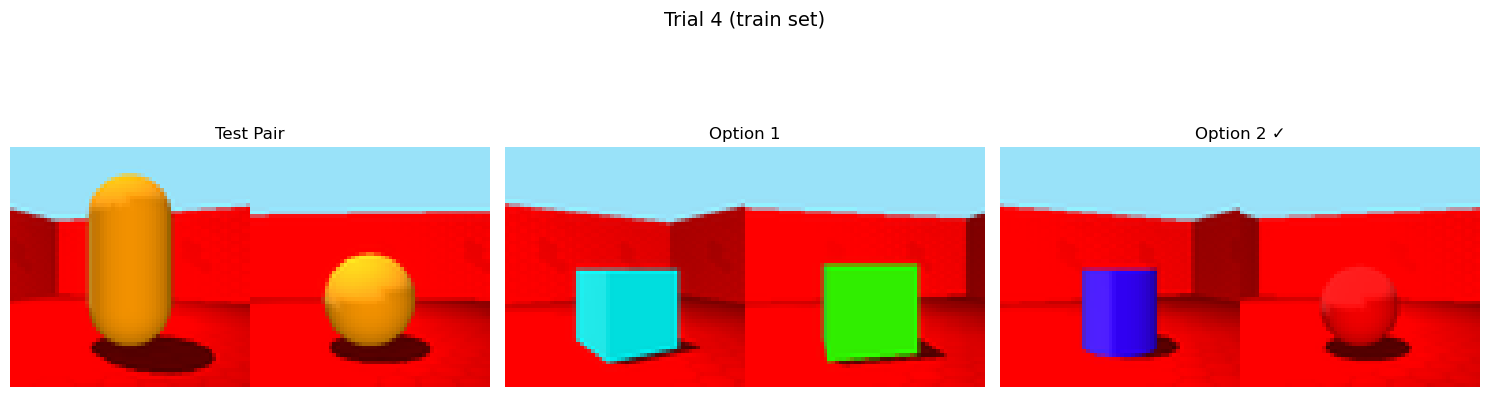


Viewing trial 5
Correct Option: 1
Metadata: {'test_categories': (3, 3), 'is_same': True, 'trial_type': 'same'}


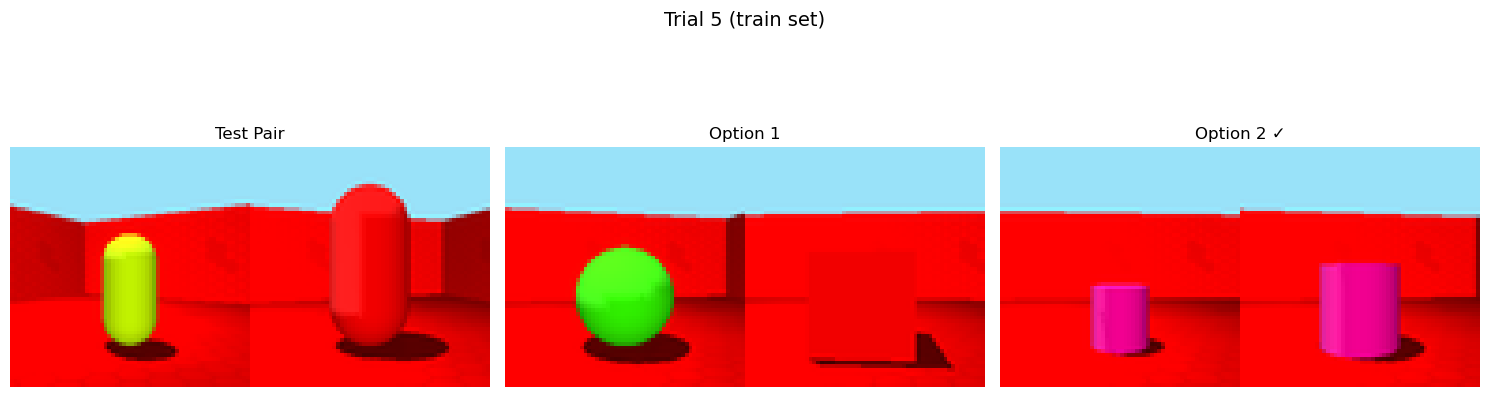


Viewing trial 6
Correct Option: 1
Metadata: {'test_categories': (3, 2), 'is_same': False, 'trial_type': 'different'}


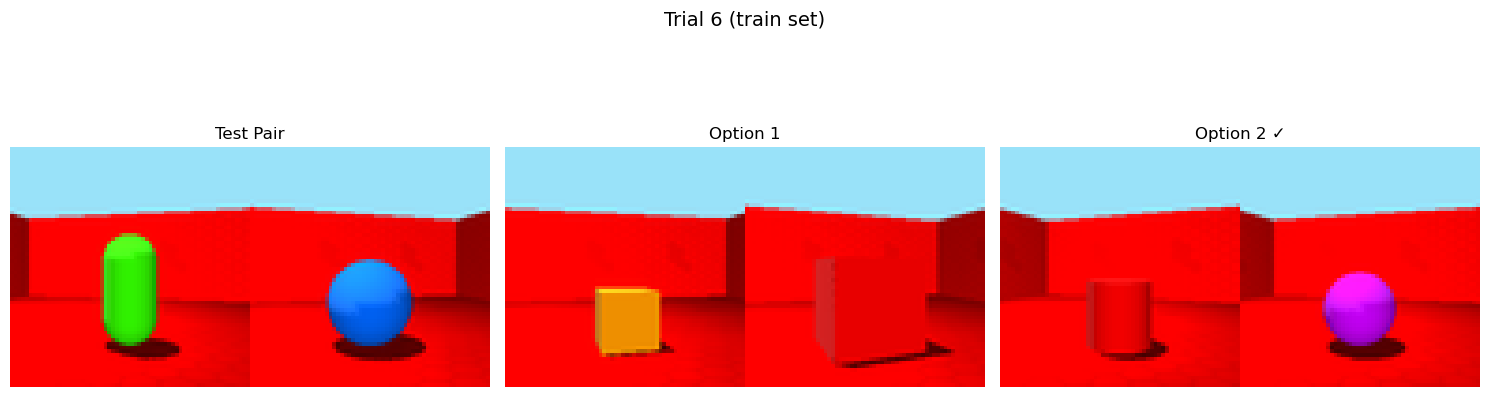


Viewing trial 7
Correct Option: 0
Metadata: {'test_categories': (0, 0), 'is_same': True, 'trial_type': 'same'}


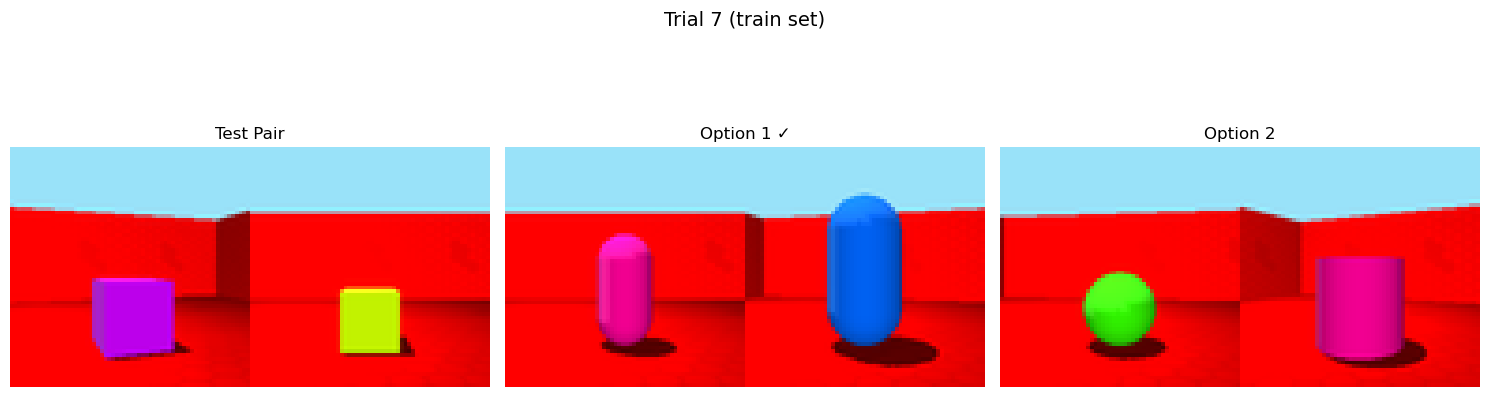

In [20]:
view_multiple_trials(a, 0, 10, 'train')


Viewing trial 0
Correct Option: 1
Metadata: {'test_categories': (3, 1), 'is_same': False, 'trial_type': 'different'}


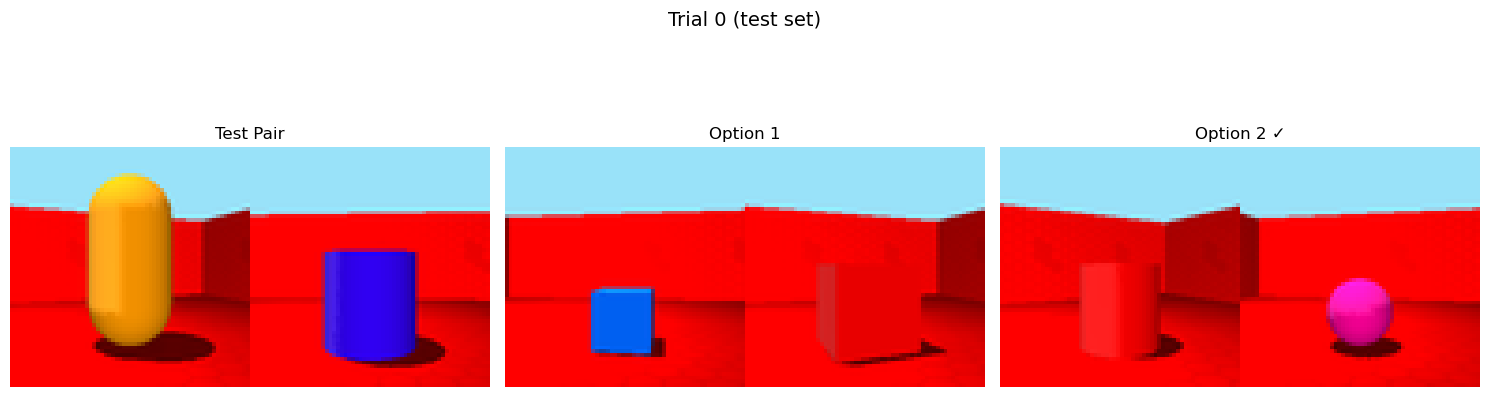


Viewing trial 1
Correct Option: 0
Metadata: {'test_categories': (1, 3), 'is_same': False, 'trial_type': 'different'}


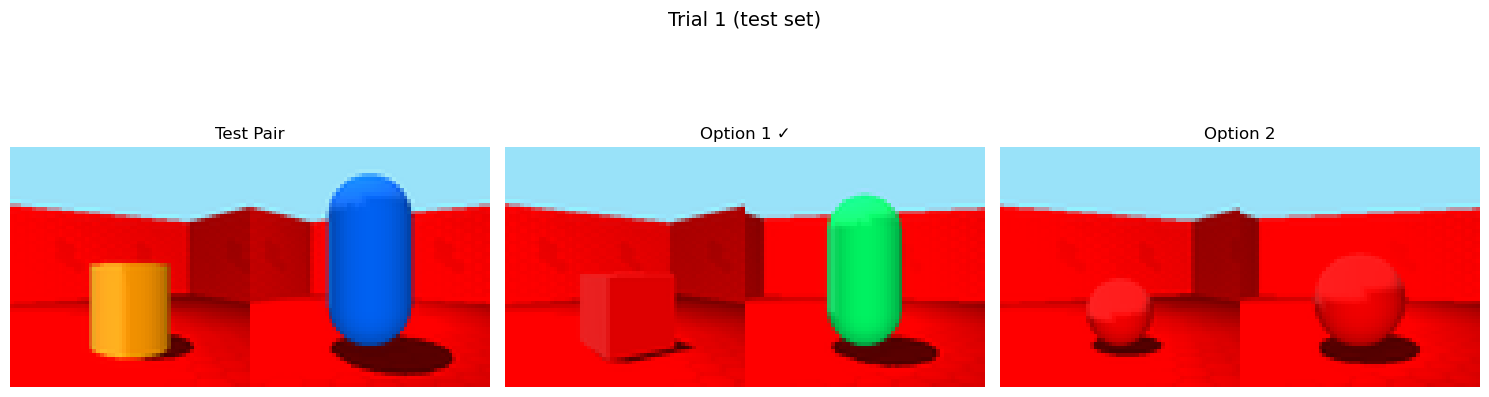

In [21]:
view_multiple_trials(a, 0, 10, 'test')

5

In [23]:
len(a['train']['metadata'])

8

In [24]:
a['train']['metadata']

[{'test_categories': (2, 2), 'is_same': True, 'trial_type': 'same'},
 {'test_categories': (3, 3), 'is_same': True, 'trial_type': 'same'},
 {'test_categories': (3, 1), 'is_same': False, 'trial_type': 'different'},
 {'test_categories': (3, 3), 'is_same': True, 'trial_type': 'same'},
 {'test_categories': (3, 2), 'is_same': False, 'trial_type': 'different'},
 {'test_categories': (3, 3), 'is_same': True, 'trial_type': 'same'},
 {'test_categories': (3, 2), 'is_same': False, 'trial_type': 'different'},
 {'test_categories': (0, 0), 'is_same': True, 'trial_type': 'same'}]